# Plotting Diabetes ROC

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import warnings
import seaborn as sns

warnings.filterwarnings('ignore')

Now we load the data

In [2]:
diabetes_data = np.loadtxt('C:/Mark/uni/Uni Work/5th Year/Diss/Coding ROC Curves in Python Diabetes/DiabetesData.csv',
                       dtype=float,
                       delimiter=',',
                       skiprows=1)

# Create healthy and diseased segements of the data
yh = diabetes_data[diabetes_data[:,1] == 0]
yd = diabetes_data[diabetes_data[:,1] == 1]
#aged30 = diabetes_data[diabetes_data[:,2] == 23]

This is what the data looks like raw, these are the first 10 rows of 286 observations. Data is organised Marker value, disease status, age. 

In [3]:
print(diabetes_data[0:10], len(diabetes_data))

[[ 82.   0.  37.]
 [112.   0.  47.]
 [ 82.   0.  20.]
 [ 87.   1.  51.]
 [ 80.   0.  54.]
 [132.   1.  48.]
 [113.   1.  49.]
 [207.   1.  63.]
 [186.   1.  70.]
 [121.   0.  62.]] 286


## 1.0 Original Data

The following cell creates historgrams for the diseased and non-diseased populations and fits a normal distribution to the data. 

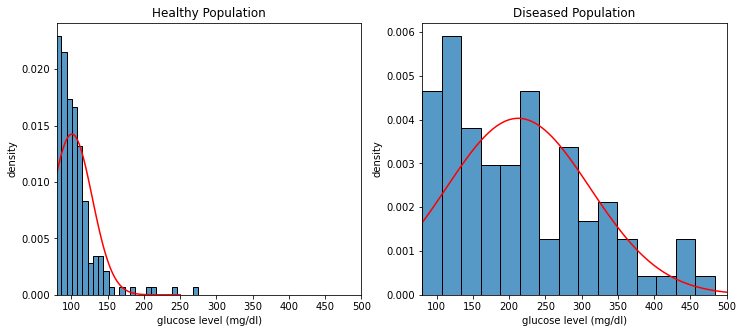

In [4]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].set_title("Healthy Population")
ax[0].set_xlim([50,250])
#ax[0].hist((yh[:,0]), bins=30, density=True)
sns.histplot(yh[:,0], ax=ax[0], bins = 30, stat='density')

mu = np.mean(yh[:,0])
sigma = np.std(yh[:,0])
x = np.linspace(50, 250, 100)
ax[0].plot(x, stats.norm.pdf(x, mu, sigma), 'r-')

ax[1].set_title("Diseased Population")
#ax[1].hist(np.transpose(yd[:,0]),bins=20, density=True)
sns.histplot(yd[:,0], ax=ax[1], bins = 15, stat='density')

mu2 = np.mean(yd[:,0])
sigma2 = np.std(yd[:,0])
x2 = np.linspace(50, 500, 100)
ax[1].plot(x2, stats.norm.pdf(x2, mu2, sigma2), 'r-')

for i in ax:
    i.set_xlim(80,500)
    i.set_xlabel('glucose level (mg/dl)')
    i.set_ylabel('density')


We want to fit a binormal ROC curve but we note that an assumption of normality is a little strange here. The data does not look overly normal. Therefore, we will make a log transform to the data and see if we can assume normality then.

## 2.0 Logarithm

The following cell creates historgrams for the diseased and non-diseased populations and fits a normal distribution to the log of the data. 

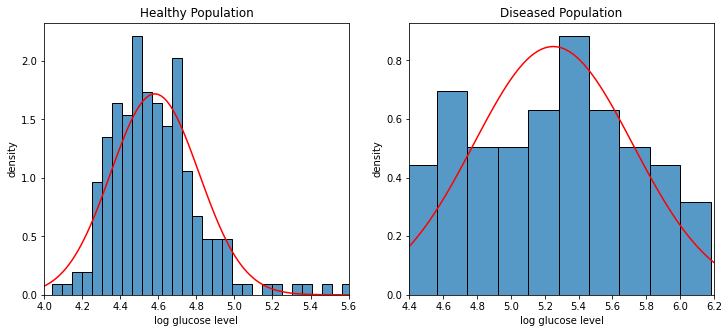

In [5]:
yhlog = np.log(yh[:, 0])
ydlog = np.log(yd[:, 0])

fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].set_title("Healthy Population")
ax[0].set_xlim([4,5.6])
sns.histplot(yhlog, ax=ax[0], bins = 30, stat='density')

mu = np.mean(yhlog)
sigma = np.std(yhlog)
x = np.linspace(4, 5.6, 100)
ax[0].plot(x, stats.norm.pdf(x, mu, sigma), 'r-')

ax[1].set_title("Diseased Population")
sns.histplot(ydlog, ax=ax[1], bins = 10, stat='density')

mu2 = np.mean(ydlog)
sigma2 = np.std(ydlog)
x2 = np.linspace(4, 6.25, 100)
ax[1].set_xlim([4.4,6.2])
ax[1].plot(x2, stats.norm.pdf(x2, mu2, sigma2), 'r-')

for i in ax:
    i.set_xlabel('log glucose level')
    i.set_ylabel('density')

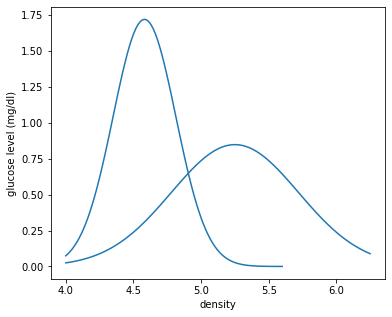

In [34]:
plt.figure(figsize=(6,5))
plt.plot(x, stats.norm.pdf(x, mu, sigma), '-', c='#1f77b4')
plt.plot(x2, stats.norm.pdf(x2, mu2, sigma2), '-', c='#1f77b4')
plt.xlabel("density")
plt.ylabel("glucose level (mg/dl)")
plt.show()

Now these distributions are more normal and we are more confident about applying the binormal ROC model. 

## 3.0 Empirical ROC and binormal ROC using ECDF

In [13]:
yh = yh[yh[:,2] >= 27]
yh = yh[yh[:,2] <= 78]

yd = yd[yd[:,2] >= 27]
yd = yd[yd[:,2] <= 78]

yh = np.log(yh[:,0])
yd = np.log(yd[:,0])

mudlog = np.mean(ydlog)
muhlog = np.mean(yhlog)
sigmadlog = np.std(ydlog)
sigmahlog = np.std(yhlog)

In [14]:
from statsmodels.distributions.empirical_distribution import ECDF

t = np.linspace(0,1,101)

# Same as result 4.7 - assuming that we are accounting for the standard normal distribution within the cdf and ppf functions. 
roccurve = 1 - stats.norm.cdf(stats.norm.ppf(1-t, muhlog, sigmahlog), mudlog, sigmadlog)

aucnorm = np.sum(roccurve)/len(t)

ecdf = ECDF(yd[:,0])

t = np.linspace(0,1,101)

roccurve_empirical = 1-ecdf(np.quantile(yh[:,0],1-t))

print(f'AUC for normal: {aucnorm}')
print(f'AUC for Empirical: {np.sum(roccurve_empirical)/len(roccurve_empirical)}')

plt.figure(figsize=(8,5))
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot(t,roccurve)
plt.plot(t,roccurve_empirical, 'r.')
plt.plot(t,roccurve_empirical, '-')

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

## 4.0 Empirical ROC and Binormal ROC Constructed 

AUC for normal: 0.8923170296161232
AUC for Empirical: 0.8919262555626192


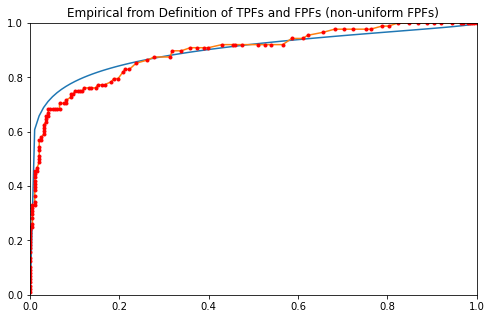

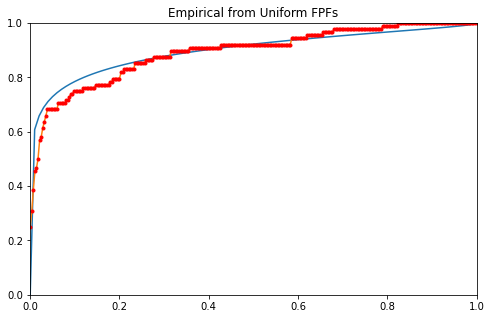

In [15]:
def empiricalROC(yh, yd):
    """
    Returns an empirical ROC for the given marker values for diseased and healthy populations.
    
    ROC curve: FPF, TPF is calculated emprically from the definitions
    ROC curve: t, TPF_emp is calculated with a uniform spacing of FPFs
    """
    y = (np.concatenate((yh, yd)))

    TPF = []
    FPF = []

    for c in np.unique(y):
        TPFnow = len([1 for j in yd if j >= c])/len(yd)
        FPFnow = len([1 for j in yh if j >= c])/len(yh)
        
        TPF = np.append(TPF, (TPFnow))
        FPF = np.append(FPF, (FPFnow))
        
    ecdf = ECDF(yd)

    t = np.linspace(0,1,286)

    TPF_emp = 1-ecdf(np.quantile(yh,1-t))
    
    return np.sort(TPF), np.sort(FPF), t, TPF_emp

t = np.linspace(0,1,101)

roccurve = 1 - stats.norm.cdf(stats.norm.ppf(1-t, muhlog, sigmahlog), mudlog, sigmadlog)

aucnorm = np.sum(roccurve)/len(roccurve)
print(f'AUC for normal: {aucnorm}')

TPF, FPF, FPF2, TPF2 = empiricalROC(yhlog, ydlog)

aucemp = np.sum(TPF2)/len(TPF2) 
print(f'AUC for Empirical: {aucemp}')

plt.figure(figsize=(8,5))
plt.title('Empirical from Definition of TPFs and FPFs (non-uniform FPFs)')
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot(t,roccurve)
plt.plot((FPF), (TPF))
plt.plot((FPF), (TPF),'r.')

plt.figure(figsize=(8,5))
plt.title('Empirical from Uniform FPFs')
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot(t,roccurve)
plt.plot((FPF2), (TPF2))
plt.plot((FPF2), (TPF2),'r.')

## 5.0 Fitting my own ROC to the data using the binormal model

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

# def norm(mu, var, statsnorm=False):
#     """
#     gives the coordinates required to plot a normal distribution given the parameters provided.
    
#     Input:
#     >>> mu  -> the mean of the distribution
#     >>> var -> the variance of the distribution
#     >>> statsnorm -> to caluclate using stats.norm.pdf or not
    
#     Output:
#     >>> x  -> the x values of the distribution (within 4 s.ds of the mean)
#     >>> y2 -> the y values calculated explicitly
#     >>> y  -> the y values calculated using stats.norm
#     """
    
#     sigma = math.sqrt(var)
#     x = np.linspace(mu-6*sigma, mu + 6*sigma, 100)
    
#     if statsnorm:
#         y = stats.norm.pdf(x, mu, sigma)
#     else:
#         y = [np.exp(-1/2*((i-mu)/sigma)**2)/ (sigma*np.sqrt(2 * np.pi)) for i in x]
#     return x, y

def norm(mu, var, statsnorm=False):
    """
    gives the coordinates required to plot a normal distribution given the parameters provided.
    
    Input:
    >>> mu  -> the mean of the distribution
    >>> var -> the variance of the distribution
    >>> statsnorm -> to caluclate using stats.norm.pdf or not
    
    Output:
    >>> x  -> the x values of the distribution (within 4 s.ds of the mean)
    >>> y2 -> the y values calculated explicitly
    >>> y  -> the y values calculated using stats.norm
    """
    
    sigma = math.sqrt(var)
    x = np.linspace(mu-6*sigma, mu +6 *sigma, 300)
    
    if statsnorm:
        y = stats.norm.pdf(x, mu, sigma)
    else:
        y = [np.exp(-1/2*((i-mu)/sigma)**2)/ (sigma*np.sqrt(2 * np.pi)) for i in x]
    return x, y

# def ROCFrom2NormalDistributions(mu1, var1, mu2, var2, printAUC=True):
#     """
#     plots the ROC curve given by two normal distributions, parameters given here
    
#     Input:
#     >>> mu1  -> mean of first distribution
#     >>> var1 -> varaince of first distribution
#     >>> mu2  -> mean of second distribution
#     >>> var2 -> varaince of second distribution
    
#     Output:
#     >>> TPF -> list of true positive values
#     >>> FPF -> list of false positive values
#     """
#     norm1x, norm1y = norm(mu1, var1)
#     norm2x, norm2y = norm(mu2, var2)
    
#     sigma1 = np.sqrt(var1)
#     sigma2 = np.sqrt(var2)
    
#     fullxs = np.concatenate((norm1x, norm2x))
#     x = np.linspace(min(fullxs), max(fullxs), 100)
    
#     FPF = [1-stats.norm.cdf(i, mu1, sigma1) for i in x]
#     TPF = [1-stats.norm.cdf(i, mu2, sigma2) for i in x]
    
#     a = (mu2-mu1)/(np.sqrt(var2))
#     b = np.sqrt(var1)/np.sqrt(var2)
       
#     if printAUC:
#         #AUC1 = np.sum(TPF)/len(TPF)
#         AUC = stats.norm.cdf(a/(np.sqrt(1+b**2)),0,1) 
#         #print(f'Avg TPF AUC: {AUC1}. Equational AUC: {AUC}')
#         print(f'AUC for curve with (mu1 = {round(mu1,3)}, var1 = {round(var1,3)}, mu2 = {round(mu2,3)}, var2 = {round(var2,3)}): {AUC}')

#     return TPF, FPF

def ROCFrom2NormalDistributions(mu1, var1, mu2, var2, printAUC=False):
    """
    plots the ROC curve given by two normal distributions, parameters given here. Assuming that mu1 <= mu2.
    That mu1 corresponds to non-diseased and mu2 to diseased.
    
    Input:
    >>> mu1  -> mean of first distribution
    >>> var1 -> varaince of first distribution
    >>> mu2  -> mean of second distribution
    >>> var2 -> varaince of second distribution
    
    Output:
    >>> TPF  -> list of true positive values calculated by averages
    >>> FPF  -> list of false positive values calculated by averages
    >>> t    -> list of uniform false positive fractions
    >>> TPF2 -> list of uniform true positive fractions
    """
    # Calculate distribution parameters
    norm1x, norm1y = norm(mu1, var1)
    norm2x, norm2y = norm(mu2, var2)
    
    sigma1 = np.sqrt(var1)
    sigma2 = np.sqrt(var2)
    
    # Find ROC = (t,ROC(t)) and print AUC as the average (uniform) TPF
    a = (mu1-mu2)/sigma2
    b = sigma1/sigma2
    
    t = np.linspace(0,1,101)
    TPF2 = [1-stats.norm.cdf(a + b * stats.norm.ppf(1-i)) for i in t]
    
#     YIarray = []
#     for i in range(len(t)):
#         YIarray.append(TPF2[i]-t[i])
    
    print(np.sum(TPF2)/len(TPF2))
    
    # Find ROC by finding TPF and FPF - Result 4.7 Pepe
    fullxs = (np.concatenate((norm1x, norm2x)))
    x = np.linspace(min(fullxs), max(fullxs), 100)
    
    FPF = [1-stats.norm.cdf(i, mu1, sigma1) for i in x]
    TPF = [1-stats.norm.cdf(i, mu2, sigma2) for i in x]
      
    AUC = stats.norm.cdf(-a/(np.sqrt(1+b**2)),0,1)
    print(f'AUC for curve with ({mu1},{var1},{mu2},{var2}): {AUC}')

    return TPF, FPF, t, TPF2

## Youden Index

In [196]:
def YoudenIndexNorm(yh, yd, reverse=False, log=False, plot=False, plotROC=False):
    """
    Calculates the YI at each point on the surface and returns an array with elements [p, q, YI_i] where
    p =p_1, 1=p_3 is a point on the surface and YI_i is the YI at that point
    """
    
    if log:
        yh = np.log(yh)
        yd = np.log(yd)

    YI = np.array([[0,0,0]])
    
    muh, mud = np.mean(yh), np.mean(yd)
    varh, vard = np.var(yh), np.var(yd)
    sigmah, sigmad = (np.std(yh)), (np.std(yd))
    
    normhx, normhy = norm(muh, varh)
    normdx, normdy = norm(mud, vard)
    
    t = np.linspace(0,1,1001)
    
    YI = np.array([0, 0, 0])
    TPF = []
    FPF = []
    
    TPF_emp = []
    
    for i in t:
        c = muh + sigmah * stats.norm.ppf(1-i)
        
        n = len(yh) + len(yd)
        
        TPF_emp.append(len([1 for j in yd if j > c])/len(yd))
        
        ROC_t = 1 - stats.norm.cdf((muh-mud)/sigmad + sigmah/sigmad * stats.norm.ppf(1-i,0,1) ,0,1)
        #print(t, ROC_t)
        
        TPF.append(ROC_t)
        FPF.append(i)
        
        YI = np.vstack((YI, np.array([i, ROC_t - i, c])))
        
    print(len(TPF), len(FPF))
    
    max_YI_index = np.argmax(YI, axis=0)[1]
    
    max_t = YI[max_YI_index, 0]
    max_YI = YI[max_YI_index, 1]
    best_c = YI[max_YI_index, 2]
    
    if plot:
        plt.figure(figsize=(6,5))
        plt.plot(normhx, normhy, 'g')
        plt.plot(normdx, normdy, 'r')
        plt.xlabel("glucose level (mg/dl)")
        plt.ylabel("density")
        plt.xlim(3.6,6.8)
        plt.ylim(0,1.75)
        
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['left'].set_visible(False)
        plt.gca().tick_params(left = False, right = False , labelleft = False, labelbottom=True)
        
        xmin, xmax, ymin, ymax = plt.axis()
        plt.plot(np.ones(2)*best_c, [ymin, ymax], 'k--')
        
    if plotROC:
        plt.figure(figsize=(6,5))
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.xlabel("FPF(c)")
        plt.ylabel("TPF(c)")
        plt.plot(t, TPF_emp, '-')
        plt.plot([0,1],[0,1], 'k--')
        plt.plot([max_t, max_t],[0.084, 0.702], 'r-')
    return YI, max_YI, max_t, best_c, max_YI_index

1001 1001
0.6793941886674862 0.084 4.9126180328807605 85
135.99498810403225


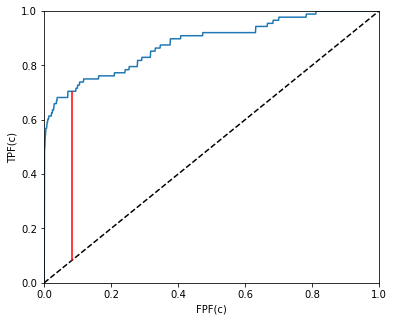

In [197]:
diabetes_data = np.loadtxt('C:/Mark/uni/Uni Work/5th Year/Diss/Coding ROC Curves in Python Diabetes/DiabetesData.csv',
                       dtype=float,
                       delimiter=',',
                       skiprows=1)

yh = diabetes_data[diabetes_data[:,1] == 0]
yd = diabetes_data[diabetes_data[:,1] == 1]

yh = yh[yh[:,2] >= 27]
yh = yh[yh[:,2] <= 78]

yd = yd[yd[:,2] >= 27]
yd = yd[yd[:,2] <= 78]

yh = (yh[:,0])
yd = (yd[:,0])

YI, max_YI, max_t, best_c, max_YI_index = YoudenIndexNorm(yh, yd, log=True, plotROC=True)
print(max_YI, max_t, best_c, max_YI_index)
print(np.exp(best_c))
#print(YI)

## Plotting ROC Emp and Binorm

The cell below plots the empirical ROC that I calculate wihtout using ECDF; also the binormal ROC that I calculcate using the two functions above and finally the binormal ROC calculated using the normal distribution in `*****` below. Note that the two binormal curves overlap.

0.8878734901462174
0.8892989458810991
AUC for curve with (4.5894831342286,0.05493563885376939,5.250175536149945,0.22148191139831028): 0.8955609368628833


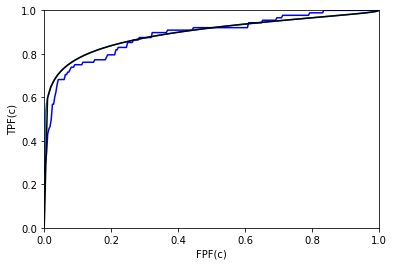

In [17]:
diabetes_data = np.loadtxt('C:/Mark/uni/Uni Work/5th Year/Diss/Coding ROC Curves in Python Diabetes/DiabetesData.csv',
                       dtype=float,
                       delimiter=',',
                       skiprows=1)

# Create healthy and diseased segements of the data
yh = (diabetes_data[diabetes_data[:,1] == 0])
yd = (diabetes_data[diabetes_data[:,1] == 1])

yh = yh[yh[:,2] >= 27]
yh = yh[yh[:,2] <= 78]

yd = yd[yd[:,2] >= 27]
yd = yd[yd[:,2] <= 78]

yh = np.log(yh[:,0])
yd = np.log(yd[:,0])

#yd = yd[:,0]
#yh = yh[:,0]

#print(len(yd),len(yh))

mu = np.mean(yh)
sigma = np.std(yh)

mu2 = np.mean(yd)
sigma2 = np.std(yd)

t = np.linspace(0, 1, 286)

roccurve = 1 - stats.norm.cdf(stats.norm.ppf(1-t, mu, sigma), mu2, sigma2) # ******

_,_,FPF1, TPF1 = empiricalROC(yh, yd)
print(np.sum(TPF1)/len(TPF1))

_,_,FPF, TPF = ROCFrom2NormalDistributions(mu, sigma**2, mu2, sigma2**2, printAUC=True)

plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("FPF(c)")
plt.ylabel("TPF(c)")
plt.plot(t,roccurve)
plt.plot((FPF1), (TPF1), 'b')
plt.plot(np.sort(FPF), np.sort(TPF), 'k')
plt.show()

## 6.0 Bootstrapping 

We do 1000 samples of the data by picking randomly 286 indices and plotting their corresponding empirical ROC. Included is the histogram of the AUCs of each of the 1000 empirical ROC curves generated above. See how it is normal. This would give us a confidence interval for our empirical AUC.

In [13]:
def AUCfromROCEmpirical(yh, yd):
    SUM = 0
    
    for i in yd:
        for j in yh:
            
            if i == j:
                AUCnow = 1/2
            elif i > j:
                AUCnow = 1
            else:
                AUCnow=0
                
            SUM += AUCnow
    
    return SUM / (len(yh)*len(yd))

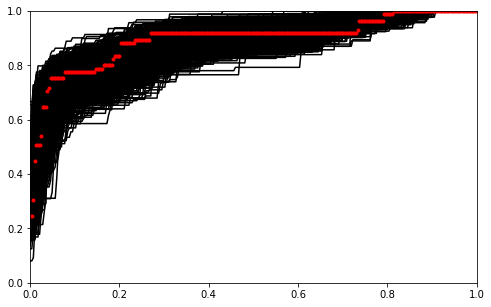

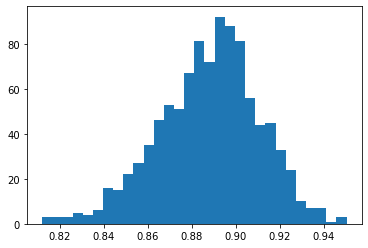

In [88]:
import random

diabetes_data = np.loadtxt('C:/Mark/uni/Uni Work/5th Year/Diss/Coding ROC Curves in Python Diabetes/DiabetesData.csv',
                       dtype=float,
                       delimiter=',',
                       skiprows=1)

data_len = len(diabetes_data)
plt.figure(figsize=(8,5))

AUCs = []
ROCs = []

for _ in range(1000):
    random_data = np.array([diabetes_data[random.randint(0, data_len-1)] for _ in range(data_len)])
    
    # Create healthy and diseased segements of the data
    yh = (random_data[random_data[:,1] == 0])
    yd = (random_data[random_data[:,1] == 1])
    
    yh = yh[yh[:,2] >= 27]
    yh = yh[yh[:,2] <= 78]

    yd = yd[yd[:,2] >= 27]
    yd = yd[yd[:,2] <= 78]

    yh = np.log(yh[:,0])
    yd = np.log(yd[:,0])

    t = np.linspace(0, 1, 286)

    _, _, FPF, TPF = empiricalROC(yh, yd)
    
    plt.plot(np.sort(FPF), np.sort(TPF), 'k-')
    
    AUCs.append(np.mean(TPF))
    ROCs.append([FPF, TPF])

plt.xlim(0,1)
plt.ylim(0,1)
plt.plot(ROCs[50][0],ROCs[50][1],'r.')
plt.figure()
plt.hist(AUCs, bins=30)
plt.show()

Now, we want to create the confidence intervals for the empirical ROC by looping over FPF values and then picking the 2.5% and 97.5% quantiles.

(1000, 2, 286)
(101,) (101,)
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09]
[0, array([0.61774194]), array([0.64210526]), array([0.66315789]), array([0.78129213]), array([0.80898876]), array([0.80898876]), array([0.80898876]), array([0.83146067]), array([0.86516854])]


C:\Users\mark\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\mark\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
C:\Users\mark\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differen

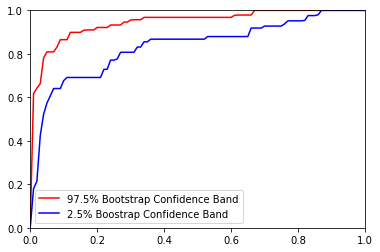

In [111]:
print(np.shape(ROCs))

FPFgrid = np.linspace(0,1,101)
ROCs = np.array(ROCs)
FPFs, TPFs = ROCs[:,0], ROCs[:,1]
t_prev = 0

TPF975s = [0]
TPF25s = [0]
TPFs_now = []

# For each region of the grid...
for t in FPFgrid[1:]:
    
    # For each ROC curve ... 
    for j in range(10):
        # Let's find all the FPFs that are lower than t
        indexes = []
        
        # This is all indexes that have an FPF between t and t-1
        for i in range(286):
            if FPFs[j,i] < t and FPFs[j,i] >= t_prev:
                indexes.append(i)
                       
        # This is all the FPFs corresponding to those indexes
        for ind in indexes:
            TPFs_now.append(TPFs[j,ind])
    
    # Find the correct quantiles of the corresponding TPFs
    TPF975 = stats.mstats.mquantiles(TPFs_now, 0.975)
    TPF25 = stats.mstats.mquantiles(TPFs_now, 0.025)
    
    # Append them to the lists of quantiles
    TPF975s.append(TPF975)
    TPF25s.append(TPF25)
    
    # Reset the TPFs now and the current quantiles
    TPFs_now = []
    TPF25 = []
    TPF975 = []
            
    # set this for [t_prev,t] so that t_prev=t-1
    t_prev = t
               
print(np.shape(FPFgrid), np.shape(TPF975s))
print(FPFgrid[0:10])
print(TPF975s[:10])
#print(indexes)
plt.plot(FPFgrid, TPF975s[:], 'r-', label='97.5% Bootstrap Confidence Band')
plt.plot(FPFgrid, TPF25s, 'b-', label='2.5% Boostrap Confidence Band')
plt.legend()
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

[0.93985416]
[0.83058483]
0.8919262555626192


C:\Users\mark\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
C:\Users\mark\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


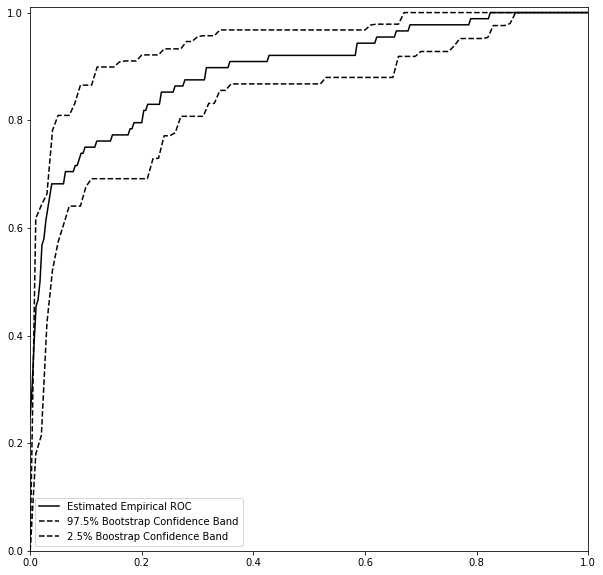

In [126]:
diabetes_data = np.loadtxt('C:/Mark/uni/Uni Work/5th Year/Diss/Coding ROC Curves in Python Diabetes/DiabetesData.csv',
                       dtype=float,
                       delimiter=',',
                       skiprows=1)

# Create healthy and diseased segements of the data
yh = (diabetes_data[diabetes_data[:,1] == 0])
yd = (diabetes_data[diabetes_data[:,1] == 1])

yh = np.log(yh[:,0])
yd = np.log(yd[:,0])
_,_,FPF1, TPF1 = empiricalROC(yh, yd)

plt.figure(figsize=(10,10))
plt.plot(FPF1, TPF1, 'k-', label='Estimated Empirical ROC')
plt.plot(FPFgrid, TPF975s, 'k--', label='97.5% Bootstrap Confidence Band')
plt.plot(FPFgrid, TPF25s, 'k--', label='2.5% Boostrap Confidence Band')

print(np.mean(TPF975s))
print(np.mean(TPF25s))
print(np.mean(TPF1))

# for i in range(len(TPF25s)):
#     if TPF25s[i]>TPF1[i]:
#         print(TPF1[i], TPF25s[i])

plt.legend()
plt.xlim(0,1)
plt.ylim(0,1.01)
plt.show()

In [17]:
a = np.array([0,1,2,3,4,5,6,7,8,9,10])

print(np.quantile(a, 0.975))

9.75


In [146]:
def bootstrap_confidence_intervals(n, data, upperpctCI=0.975, lowerpctCI=0.025, log = True):
    """
    The function takes data and fits n empirical rocs, then plots the estimate empirical ROC, the 97.5% and 2.5% from
    the boostrapped ROCs.
    
    Input:
    >>> n          number of bootstrapped sample empirical ROCs
    >>> data       Data in the form of a numpy array with first column marker values and second column disease status
    >>> upperpctCI Lower quantile of the bootstraps to take as the CI
    >>> lowerpctCI Upper quantile of the bootstraps to take as the CI 
    >>> log        Makes a log transform of the data if True
    
    Output:     
    >>> result  Dictionary with the keys 'upperCI', 'lowerCI' that has the corresponding 
                ROC (in [[FPFs], [TPFs], [AUC]]) as values. Where FPFs is a grid of 100 values and TPFs the corresponding
                100 TPFs. AUC is a float value of the area under the curves
    """
    
    data_len = len(data)
    
    AUCs = []
    ROCs = []

    for _ in range(n):
        random_data = np.array([data[random.randint(0, data_len-1)] for _ in range(data_len)])

        yh = (random_data[random_data[:,1] == 0])
        yd = (random_data[random_data[:,1] == 1])
        
        if log:
            yh = np.log(yh[:,0])
            yd = np.log(yd[:,0])

        _, _, FPF, TPF = empiricalROC(yh, yd)

        AUCs.append(np.mean(TPF))
        ROCs.append([FPF, TPF])

    # Now we have constructed each of the ROCs
    
    FPFgrid = np.linspace(0,1,100)
    ROCs = np.array(ROCs)
    FPFs, TPFs = ROCs[:,0], ROCs[:,1]
    t_prev = 0

    TPF975s = [0]
    TPF25s = [0]
    TPFs_now = []

    # For each region of the grid...
    for t in FPFgrid[1:]:

        # For each ROC curve ... 
        for j in range(n):
            # Let's find all the FPFs that are lower than t
            indexes = []

            # This is all indexes that have an FPF between t and t-1
            for i in range(data_len):
                if FPFs[j,i] < t and FPFs[j,i] >= t_prev:
                    indexes.append(i)

            # This is all the FPFs corresponding to those indexes
            for ind in indexes:
                TPFs_now.append(TPFs[j,ind])

        # Find the correct quantiles of the corresponding TPFs
        TPF975 = stats.mstats.mquantiles(TPFs_now, upperpctCI)
        TPF25 = stats.mstats.mquantiles(TPFs_now, lowerpctCI)

        # Append them to the lists of quantiles
        TPF975s.append(TPF975)
        TPF25s.append(TPF25)

        # Reset the TPFs now and the current quantiles
        TPFs_now = []
        TPF25 = []
        TPF975 = []

        # set this for [t_prev,t] so that t_prev=t-1
        t_prev = t
    
    result = {}
    
    result['upperCI'] = [[FPFgrid], [TPF975s], [np.mean(TPF975s)]]
    result['lowerCI'] = [[FPFgrid], [TPF25s], [np.mean(TPF25s)]]
    
    return result

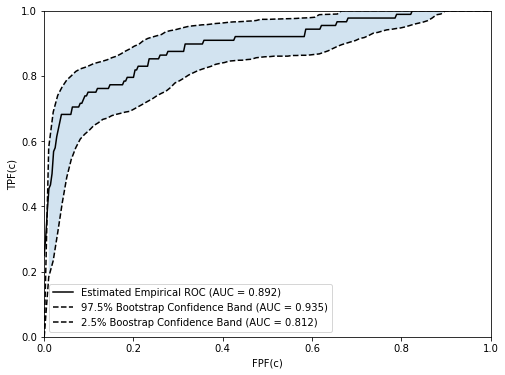

In [184]:
diabetes_data = np.loadtxt('C:/Mark/uni/Uni Work/5th Year/Diss/Coding ROC Curves in Python Diabetes/DiabetesData.csv',
                       dtype=float,
                       delimiter=',',
                       skiprows=1)

data = diabetes_data[diabetes_data[:,2] >= 27]
data = data[data[:,2] <= 78]

# Create healthy and diseased segements of the data
yh = (diabetes_data[diabetes_data[:,1] == 0])
yd = (diabetes_data[diabetes_data[:,1] == 1])

yh = np.log(yh[:,0])
yd = np.log(yd[:,0])

_, _, FPF1, TPF1 = empiricalROC(yh, yd)
bootstraps = bootstrap_confidence_intervals(2000, data)

upperCI = bootstraps['upperCI']
lowerCI = bootstraps['lowerCI']

TPFlowerCI = lowerCI[1][0]
TPFupperCI = upperCI[1][0]
FPF = lowerCI[0][0]

#print(([float(i) for i in TPFlowerCI]))

TPFlowerCI = [float(i) for i in TPFlowerCI]
TPFupperCI = [float(i) for i in TPFupperCI]

TPFlowerCI = [1 if np.isnan(i) else i for i in TPFlowerCI]
TPFupperCI = [1 if np.isnan(i) else i for i in TPFupperCI]

# TPFlowerCI = [np.ma.filled(i, fill_value=1) for i in TPFlowerCI if type(i) is np.ndarray]
# TPFupperCI = [np.ma.filled(i, fill_value=1) for i in TPFupperCI if type(i) is np.ndarray]

# TPFlowerCI = [float(i[0]) for i in TPFlowerCI]
# TPFupperCI = [float(i[0]) for i in TPFupperCI]

# print(lowerCI[0])
# print(upperCI[0])
#print(TPFlowerCI)
#print(TPFupperCI)
#print(FPF)
#print((TPFlowerCI))
#print(type(FPF))

#print(np.shape(TPF1), np.shape(TPFlowerCI), np.shape(TPFupperCI))

upperAUC = np.mean(TPFupperCI)
lowerAUC = np.mean(TPFlowerCI)
empAUC = np.mean((TPF1))
#print(lowerAUC, empAUC, upperAUC)

#lowerCI[0][0]
#np.array(lowerCI[1][0]).fill(1)

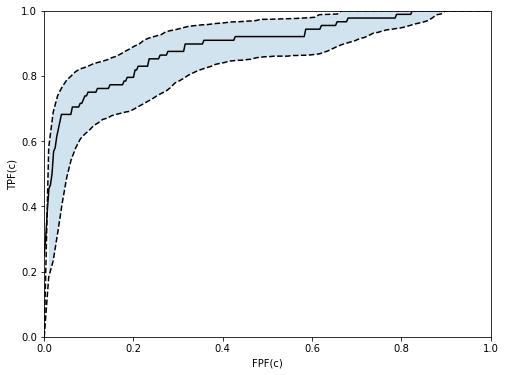

In [186]:
plt.figure(figsize=(8,6))

plt.plot(FPF1, TPF1, 'k-', label=f'Estimated Empirical ROC (AUC = {round(empAUC,3)})')
plt.plot(FPF, TPFlowerCI, 'k--', label=f'97.5% Bootstrap Confidence Band (AUC = {round(upperAUC,3)})')
plt.plot(FPF, TPFupperCI, 'k--', label=f'2.5% Boostrap Confidence Band (AUC = {round(lowerAUC,3)})')

lowerCI1D = [i[0] for i in lowerCI[1][0][1:]]
upperCI1D = [i[0] for i in upperCI[1][0][1:]]

#plt.legend()
plt.fill_between(lowerCI[0][0][1:], lowerCI1D, upperCI1D, alpha=0.2)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("FPF(c)")
plt.ylabel("TPF(c)")
plt.show()